In [1]:
import os
import time
from typing import Union

import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfms
from tqdm import tqdm

from .dataprocess import SegmentationDataset
from .model import UNet, UNetPlus, HRDA, AdaptorVit
from .utils import show_batch, all_metrics, during_loss

In [2]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 Tesla V100-PCIE-32GB


In [3]:
INIT_LR = 0.001
NUM_EPOCHS = 500
BATCH_SIZE = 32
IMG_SIZE = 800
EXP_NAME = "expA5"

raw_images = np.concatenate([np.load(f"imgs{chr(i)}.npy") for i in range(15)], axis=0)
raw_masks = np.concatenate([np.load(f"msks{chr(i)}.npy") for i in range(15)], axis=0)
split = [7, 1, 2]

# print(raw_images.shape, raw_masks.shape)

In [4]:
d_setting = {
    images=raw_images,
    masks=raw_masks,
    splitRatio=split,
    xfm_img=xfms.Compose([xfms.Normalize(2428.6, 3513.6)]),
}

tds = SegmentationDataset(split='train',
                          xfm=xfms.Compose([xfms.ToTensor(), 
                                            xfms.RandomCrop((IMG_SIZE, IMG_SIZE)), 
                                            xfms.RandomRotation(90), 
                                            xfms.RandomHorizontalFlip()]),
                          **d_setting)
tdl = DataLoader(tds, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)

vds = SegmentationDataset(split='valid',
                          xfm=xfms.Compose([xfms.ToTensor(), 
                                            xfms.RandomCrop((IMG_SIZE, IMG_SIZE))]),
                          **d_setting)
vdl = DataLoader(vds, batch_size=999, shuffle=True, num_workers=12, pin_memory=True)

ttds = SegmentationDataset(split='test',    
                           xfm=xfms.Compose([xfms.ToTensor(), 
                                             xfms.RandomCrop((IMG_SIZE, IMG_SIZE))]),
                           **d_setting)
ttdl = DataLoader(ttds, batch_size=1999, shuffle=False, num_workers=12, pin_memory=True)

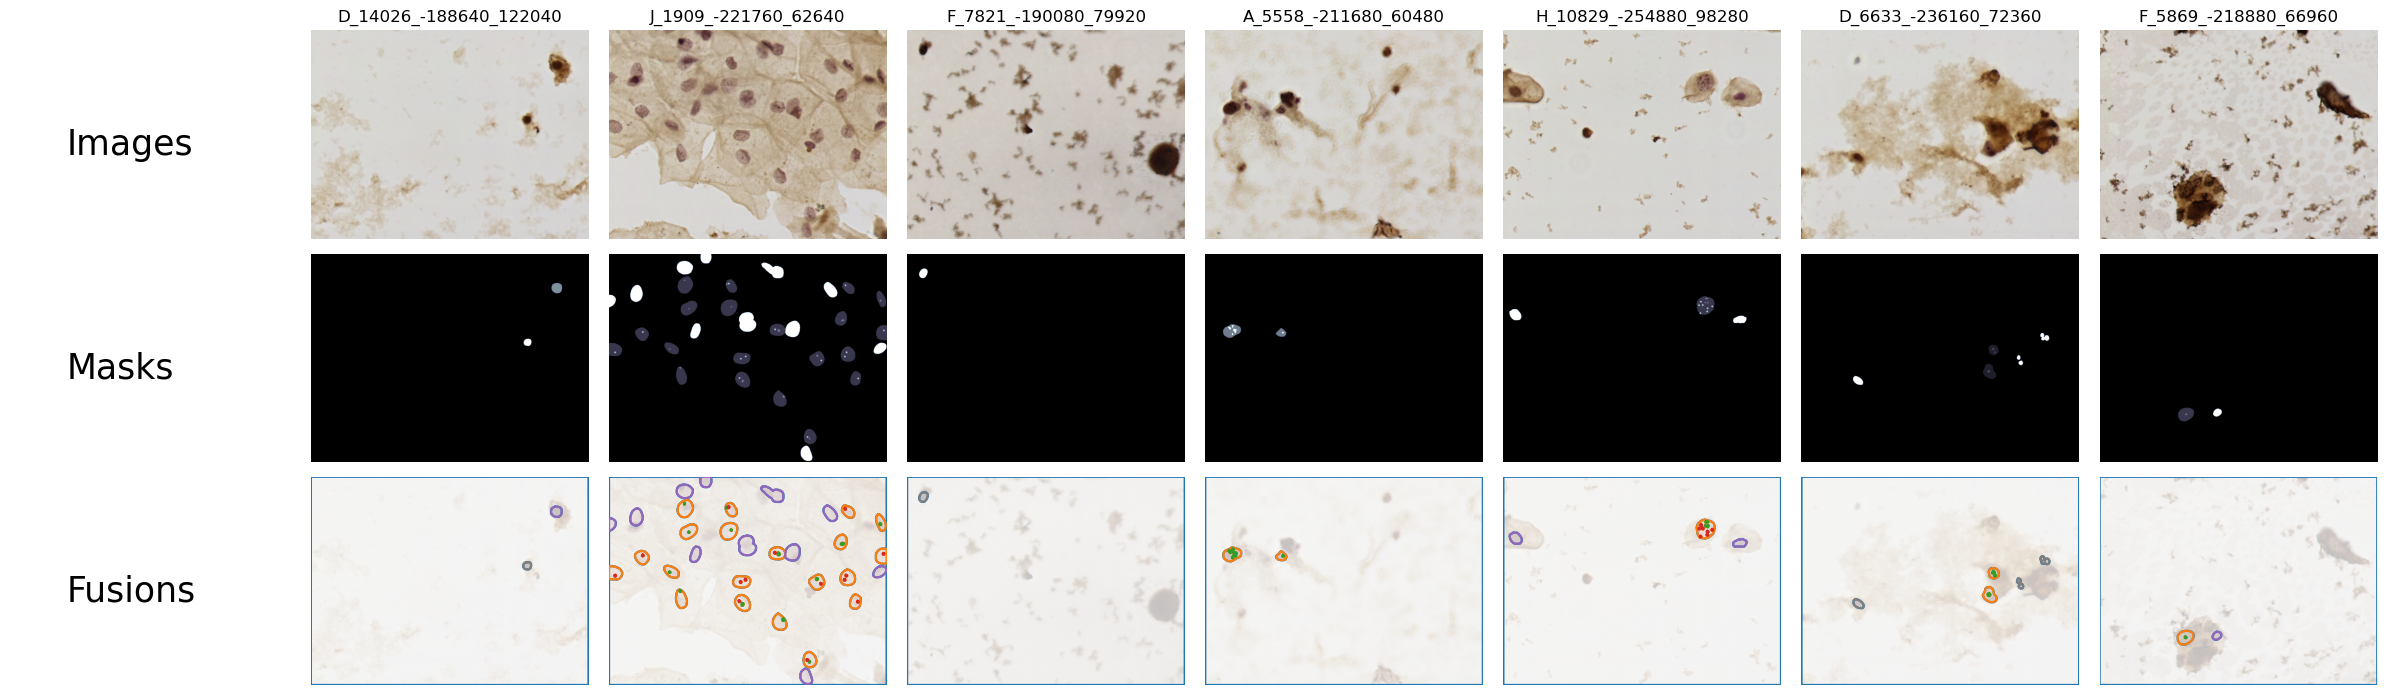

In [5]:
for i, (imgs, masks) in enumerate(tdl):
    print(imgs.shape, masks.shape)
    show_batch(7, 3, imgs, masks, mode=1)
    break

In [16]:
unet = torch.nn.DataParallel(UNet(encChannels=(1, 16, 32, 64, 128), 
                                  decChannels=(64, 32, 16), 
                                  backBone='Resnet',
                                  outSize=(IMG_SIZE, IMG_SIZE),
                                  numClass=8,
                                 ).to(device), 
                             device_ids=[1, 0, 3, 2])
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
H = {"train_loss": [], "test_loss": []}

In [17]:
# train
print("[INFO] training the network...")
startTime = time.time()
e_bar = tqdm(range(NUM_EPOCHS))
for e in e_bar:
    unet.train()
    totalTrainLoss = torch.Tensor([0]).to(device)
    totalTestLoss = torch.Tensor([0]).to(device)
    for (i, (x, y, _)) in enumerate(tdl):
        (x, y) = (x.to(device), y.to(device))
        pred = unet(x)
        loss = lossFunc(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss
    # val
    anno = ""
    with torch.no_grad():
        unet.eval()
        for (x, y, _) in vdl:
            (x, y) = (x.to(device), y.to(device))
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
            anno = all_metrics(pred, y, show=False)
            
    # calculate the average training and validation loss
    avgTrainLoss = (totalTrainLoss.cpu().item() / len(tdl))
    avgTestLoss = (totalTestLoss.cpu().item() / len(vdl))
    if H["test_loss"] and avgTestLoss < np.min(H["test_loss"]):
        torch.save(unet.state_dict(), f"exp9/{avgTestLoss:.4f}_{e+1:03}.pth")
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["test_loss"].append(avgTestLoss)
    # print the model training and validation information
    e_bar.set_description(f"#{e+1:03}, tl:{avgTrainLoss:.4f}, vl:{avgTestLoss:.4f}\n{anno}")
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


#1500, tl:0.0285, vl:0.0252, mAP@[.5:.95:.05]:0.88, PA:0.91, mPA:0.90, Dice:0.96, IoU:0.92, mIoU:0.86: 100%|██████████| 1500/1500 [3:18:22<00:00, 7.92s/it]

[INFO] total time taken to train the model: 11902.23s


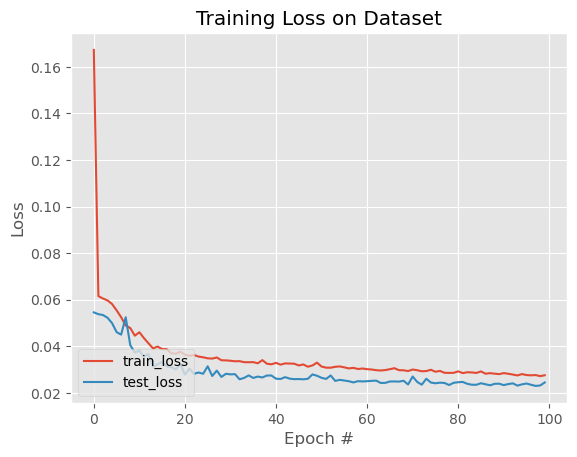

In [18]:
during_loss(H, 'Training Loss on Dataset')

In [19]:
unet.load_state_dict(torch.load("/root/NYCU_DL_2022/A5/best.pth"))

In [20]:
# test
with torch.no_grad():
    unet.eval()
    for (x, y, _) in ttdl:
        (x, y) = (x.to(device), y.to(device))
        pred = unet(x)
        totalTestLoss += lossFunc(pred, y)
        anno = all_metrics(pred, y, show=False)
        print(anno)

mAP@[.5:.95:.05]:0.86, PA:0.87, mPA:0.89, Dice:0.93, IoU:0.86, mIoU:0.83

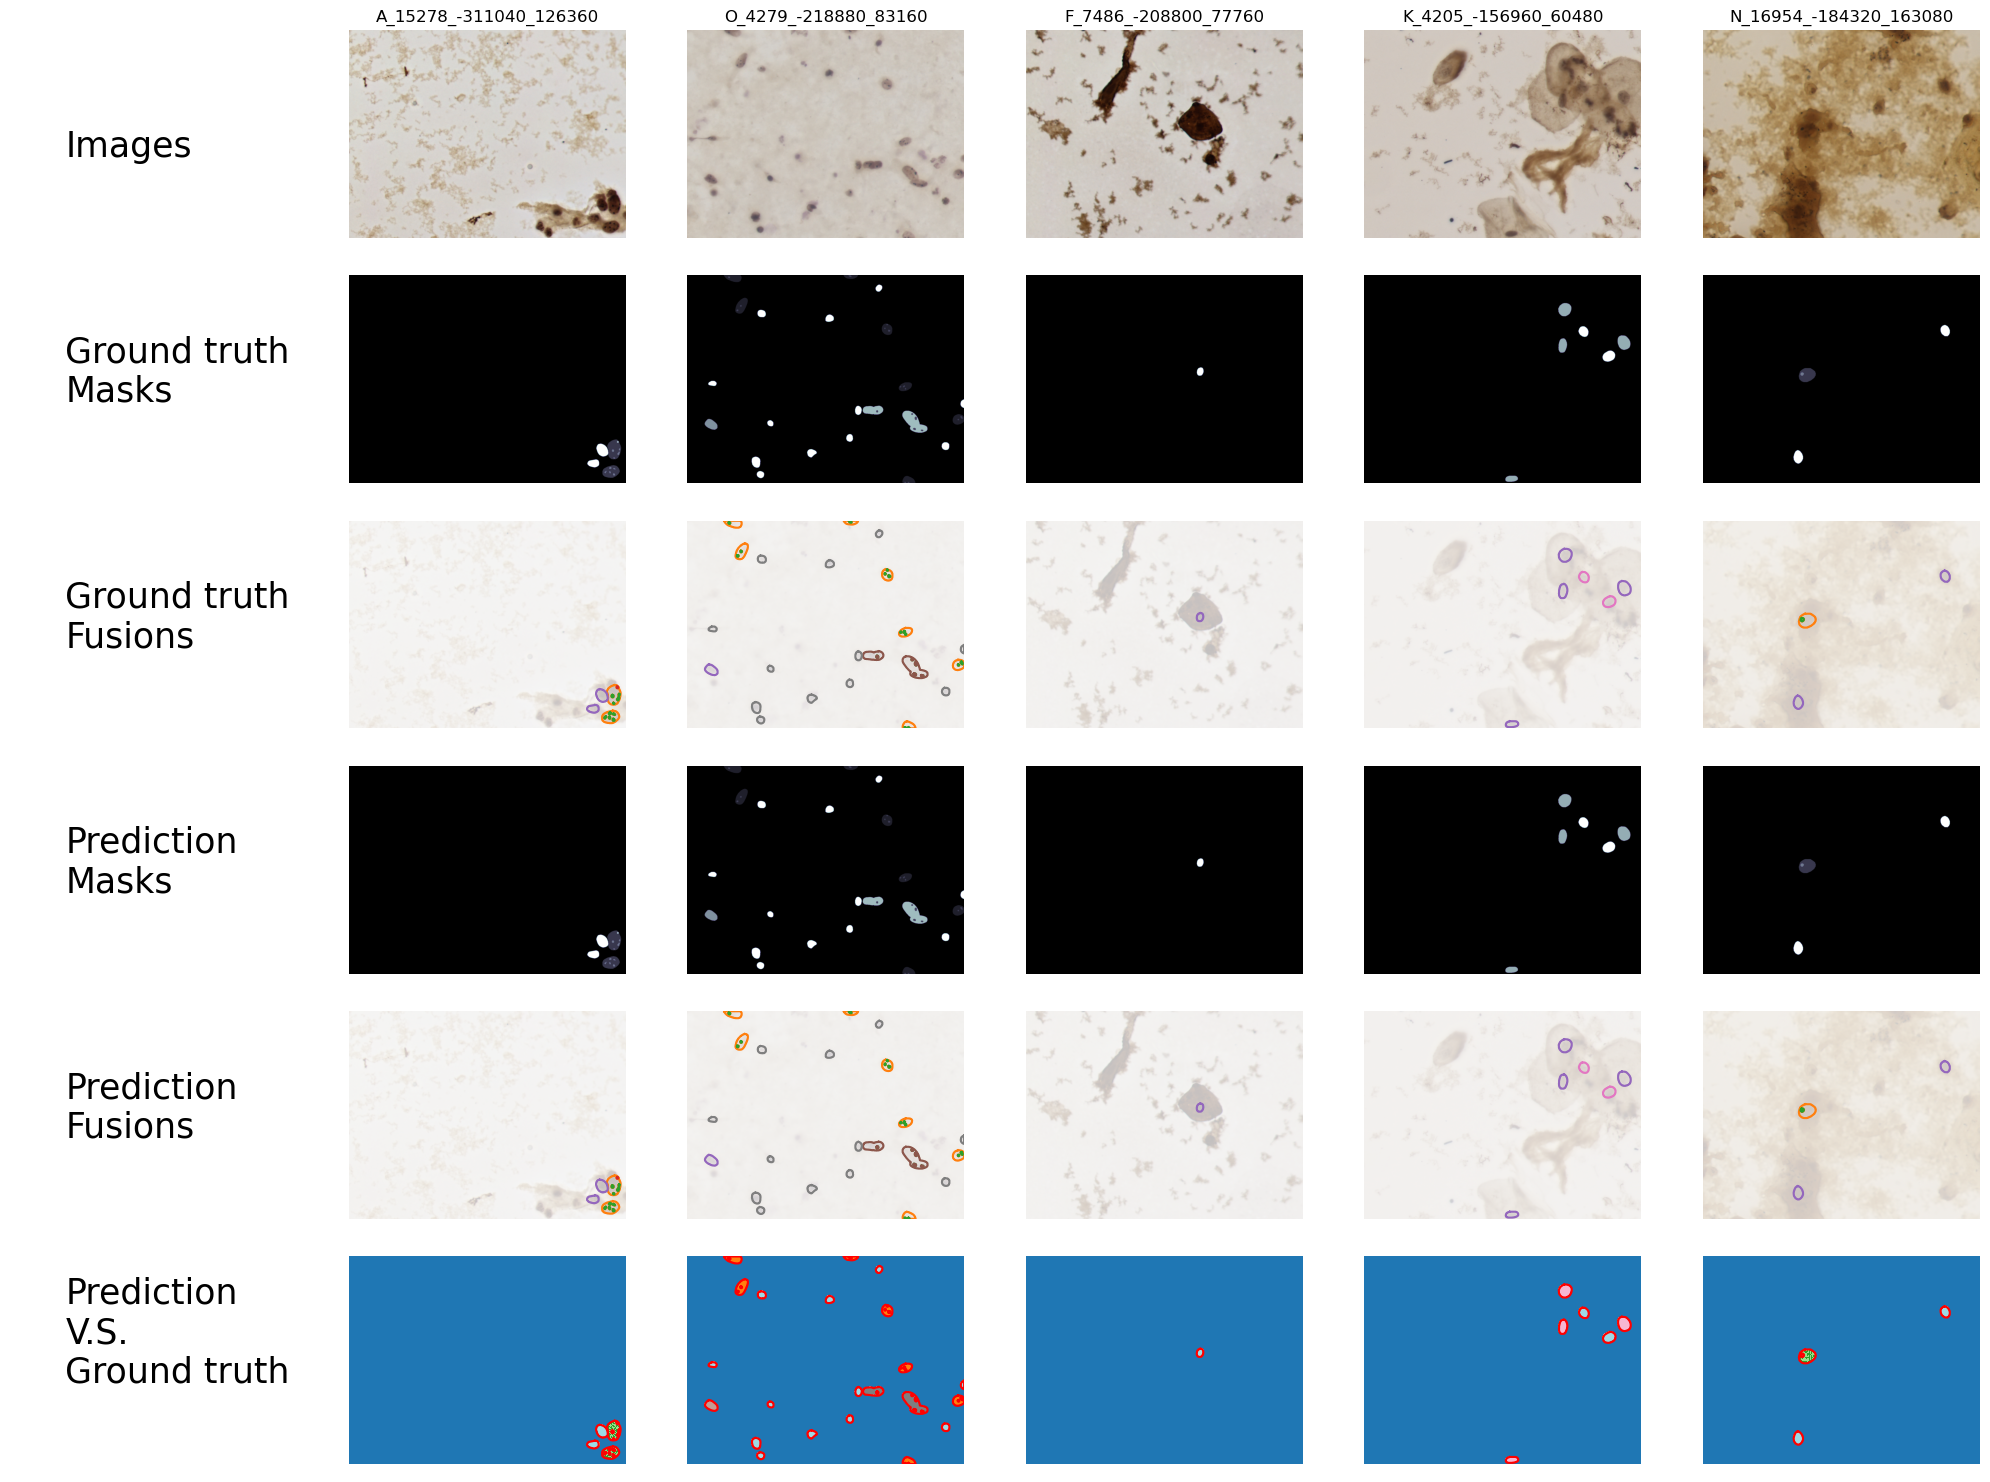

In [21]:
# test
ttdl = DataLoader(ttds, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True)
with torch.no_grad():
    unet.eval()
    for (x, y, names) in ttdl:
        (x, y) = (x.to(device), y.to(device))
        pred = unet(x)
        totalTestLoss += lossFunc(pred, y)
        show_batch(6, 6, imgs, masks, pred, mode=2, names=names)
        break